In [ ]:
!pip install np_utils
!pip install keras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56437 sha256=6a5afa83b1ac1a4bc2cc77aa220ef80896ece680738e14d228184d397b0be07c
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical # import to_categorical from the correct module.
 # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
X_train = np.load("/content/drive/MyDrive/inner+outer tests/X_train_inner+outer_rings.npy")

In [ ]:
y_train = np.load("/content/drive/MyDrive/inner+outer tests/train_labels_inner+outer_rings.npy")

In [ ]:
X_val = np.load("/content/drive/MyDrive/inner+outer tests/X_val_inner+outer_rings.npy")

In [ ]:
y_val = np.load("/content/drive/MyDrive/inner+outer tests/val_labels_inner+outer_rings.npy")

In [ ]:
X_train.shape, X_val.shape

((8012, 192, 256, 3), (2003, 192, 256, 3))

In [ ]:
y_train.shape, y_val.shape

((8111,), (902,))

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
pre_trained_model = InceptionV3(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [ ]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 6, 2048)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 95, 127, 32)          864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 95, 127, 32)          96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 95, 127, 32)          0         ['batch_normalization[0][0

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [ ]:
# batch_size = 64
# epochs = 3
# history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
#                               verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
#                               validation_steps=(X_val.shape[0] // batch_size))
# Check data generators
batch_size = 64
epochs = 3
for X_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size=batch_size):
    print(X_batch.shape, y_batch.shape)
    break

for X_batch, y_batch in val_datagen.flow(X_val, y_val, batch_size=batch_size):
    print(X_batch.shape, y_batch.shape)
    break

# Run the model eagerly for better debugging
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)


history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=val_datagen.flow(X_val, y_val),
    verbose=1,
    steps_per_epoch=(X_train.shape[0] // batch_size),
    validation_steps=(X_val.shape[0] // batch_size)
)


(64, 192, 256, 3) (64, 7)
(64, 192, 256, 3) (64, 7)
Epoch 1/3


125/125 [==============================] - 172s 1s/step - loss: 1.5411 - accuracy: 0.6404 - val_loss: 3.0195 - val_accuracy: 0.6452
Epoch 2/3
125/125 [==============================] - 153s 1s/step - loss: 1.0228 - accuracy: 0.6677 - val_loss: 1.0164 - val_accuracy: 0.6573
Epoch 3/3
125/125 [==============================] - 145s 1s/step - loss: 0.9875 - accuracy: 0.6699 - val_loss: 0.9041 - val_accuracy: 0.6885


In [ ]:
for layer in pre_trained_model.layers[249:]:
    layer.trainable = True

In [ ]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5,
                                            min_lr=0.000001, cooldown=2)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 95, 127, 32)          864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 95, 127, 32)          96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 95, 127, 32)          0         ['batch_normalization[0][0

In [ ]:

# history = model.fit(
#     train_datagen.flow(X_train, y_train, batch_size=batch_size),
#     epochs=epochs,
#     validation_data=val_datagen.flow(X_val, y_val),
#     verbose=1,
#     steps_per_epoch=(X_train.shape[0] // batch_size),
#     validation_steps=(X_val.shape[0] // batch_size)
# )

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

callbacks = [learning_rate_reduction, early_stopping]

batch_size = 64
epochs = 35
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=callbacks)

Epoch 1/35
125/125 [==============================] - 158s 1s/step - loss: 0.9790 - accuracy: 0.6720 - val_loss: 1.1918 - val_accuracy: 0.6754 - lr: 0.0010
Epoch 2/35
125/125 [==============================] - 143s 1s/step - loss: 0.8885 - accuracy: 0.6841 - val_loss: 0.9185 - val_accuracy: 0.7198 - lr: 0.0010
Epoch 3/35
125/125 [==============================] - 143s 1s/step - loss: 0.8501 - accuracy: 0.6926 - val_loss: 0.8081 - val_accuracy: 0.7077 - lr: 0.0010
Epoch 4/35
125/125 [==============================] - 148s 1s/step - loss: 0.8389 - accuracy: 0.6948 - val_loss: 0.8578 - val_accuracy: 0.6925 - lr: 0.0010
Epoch 5/35
125/125 [==============================] - ETA: 0s - loss: 0.8313 - accuracy: 0.6974
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
125/125 [==============================] - 143s 1s/step - loss: 0.8313 - accuracy: 0.6974 - val_loss: 0.7751 - val_accuracy: 0.7127 - lr: 0.0010
Epoch 6/35
125/125 [==============================] - 144s 

In [ ]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

63/63 [==============================] - 14s 229ms/step - loss: 0.7467 - accuracy: 0.7274
Validation: accuracy = 0.727409  ;  loss_v = 0.746729


In [ ]:
X_test = np.load("/content/drive/MyDrive/tests for SURF/outer tests/outer_ring_test_500.npy")

In [ ]:
y_test = np.load("/content/drive/MyDrive/tests for SURF/outer tests/outer_ring_test_500_labels.npy")
y_test = to_categorical(y_test)

In [ ]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

16/16 [==============================] - 5s 247ms/step - loss: 1.1726 - accuracy: 0.5600
Test: accuracy = 0.560000  ;  loss = 1.172593


In [ ]:
from sklearn.metrics import classification_report

y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert true labels to integer form if necessary
y_test_labels = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_test_labels, y_pred, output_dict=True)
print(report)

# Extract overall metrics
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']
print("Overall Precision: ", precision)
print("Overall Recall: ", recall)
print("Overall F1-Score: ", f1_score)

16/16 [==============================] - 4s 188ms/step
{'0': {'precision': 0.2222222222222222, 'recall': 0.26666666666666666, 'f1-score': 0.2424242424242424, 'support': 15.0}, '1': {'precision': 0.08450704225352113, 'recall': 0.5714285714285714, 'f1-score': 0.147239263803681, 'support': 21.0}, '2': {'precision': 0.2127659574468085, 'recall': 0.17857142857142858, 'f1-score': 0.1941747572815534, 'support': 56.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}, '4': {'precision': 0.8664383561643836, 'recall': 0.7397660818713451, 'f1-score': 0.7981072555205049, 'support': 342.0}, '5': {'precision': 1.0, 'recall': 0.125, 'f1-score': 0.2222222222222222, 'support': 8.0}, '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 51.0}, 'accuracy': 0.56, 'macro avg': {'precision': 0.34084765401241934, 'recall': 0.26877610693400167, 'f1-score': 0.2291668201788863, 'support': 500.0}, 'weighted avg': {'precision': 0.6426895852917955, 'recall': 0.56, 'f1-score': 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save("InceptionV3FT_inner+outer.keras")

Text(0.5, 1.0, 'Training and validation loss')

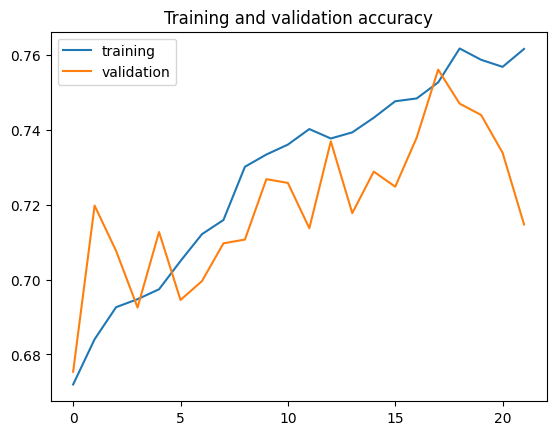

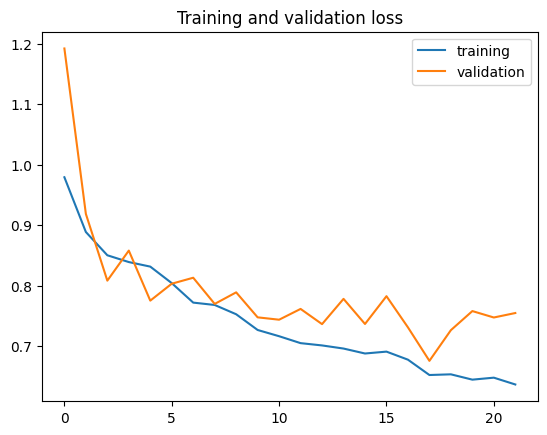

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')